# TransparentCalifornia Cohort Analysis

This notebook tries to take yearly public salary data and create cohorts over time of similar rows by grouping by
- Year 
- Number of years employed by the State of California
- Number of years with a Job Title
- Job Title

This, for example, puts all the 2013 salary entries for people who started state service in 2012 as 
Correctional Officers who stayed in the same job in 2013 as a cohort.

This makes it possible to compare cohorts over time and try to approximately answer questions like these:
- Did people who made below median salary in their cohort in one year continue to be below median <x> years later?
- How substantial is the effect?
- Is there a difference in median salary between men and women in a particular cohort?

## Import Libraries

In [1]:
import sys
!{sys.executable} -m pip install pandas matplotlib ipywidgets scipy pandas_profiling > /dev/null
!{sys.executable} -m pip install genderize gender_guesser seaborn statsmodels datadotworld[pandas] > /dev/null
!{sys.executable} -m pip install pandasql > /dev/null


import requests
from io import StringIO
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib
%matplotlib inline
from genderize import Genderize
import gender_guesser.detector as gender
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import datadotworld as dw
import sqlite3
import warnings
from pandasql import sqldf
warnings.simplefilter(action='ignore', category=FutureWarning)


You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Read in data from TransparentCalifornia

In [2]:
df = None
for year in range(2011,2020):    
    year_df = pd.read_csv(f'TransparentCalifornia/state-of-california-{year}.csv.zip', compression='zip')
    for col in ['Base Pay', 'Benefits', 'Other Pay', 'Total Pay', 'Overtime Pay', 'Total Pay & Benefits']:
        year_df[col] = pd.to_numeric(year_df[col], errors='coerce').astype('float64').round(2)
    year_df['Job Title'] = year_df['Job Title'].str.title().str.strip()
    year_df['Employee Name'] = year_df['Employee Name'].str.title()
    print(f'Year {year} Rows {len(year_df)}')
    df = year_df if df is None else df.append(year_df)

Year 2011 Rows 246599
Year 2012 Rows 244881
Year 2013 Rows 235071
Year 2014 Rows 240531
Year 2015 Rows 246273


/Users/bryanchan/.pyenv/versions/3.7.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Year 2016 Rows 248279
Year 2017 Rows 247697
Year 2018 Rows 253503
Year 2019 Rows 260277


In [3]:
print(df.dtypes)

Employee Name            object
Job Title                object
Base Pay                float64
Overtime Pay            float64
Other Pay               float64
Benefits                float64
Total Pay               float64
Total Pay & Benefits    float64
Year                      int64
Notes                    object
Agency                   object
Status                   object
dtype: object


# Guess at Genders from Names

In [4]:
df['First Name'] = df['Employee Name'].str.split(n=2).str[0]

In [5]:
d = gender.Detector()
df['Gender'] = df['First Name'].apply(lambda name: d.get_gender(name.title()))

In [6]:
df[['First Name', 'Gender']][0:100]

,First Name,Gender
0,Mohammad,male
1,Gertrudis,female
2,Joseph,male
3,Thomas,male
4,Curtis,male
...,...,...
95,Michael,male
96,Theodore,male
97,Dennis,male
98,Wadsworth,unknown


### Gender Distribution

<AxesSubplot:>

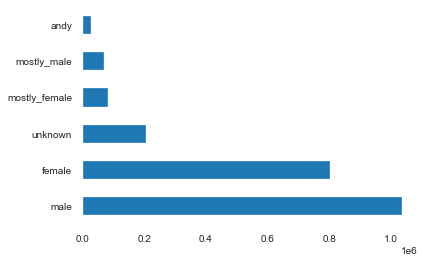

In [7]:
df['Gender'].value_counts().plot(kind='barh')

# Plot the Non-Adjusted Gender Gap
Note on how to interpret this -- it's an interesting barometer, but does not by itself point towards any specific causes of disparity

In [8]:
median_salary_df = df.groupby(['Gender'])['Base Pay'].median()
median_salary_df.sort_values()

Gender
female           51399.610
mostly_female    53748.000
unknown          55787.495
mostly_male      59676.845
andy             60797.245
male             63782.960
Name: Base Pay, dtype: float64

# Create Cohorts for Comparison
Try to create groups of people who started with Job Title `A` in a particular year and had Job Title `B` in a later year.

To avoid comparing apples to oranges, we want to only include people of roughly equal seniority in state service in the cohort.  And only want to compare people who did not switch roles in the years of interest (which makes understanding base salary difficult). 

Let's build cohorts step by step:

### 1) Group to one row per Employee Name per Year

In [9]:
initial_length = len(df)
print(f'Initial length rows={len(df)}')

df['Year in Job'] = df.groupby(['Employee Name', 'Job Title'])['Year'].rank("dense", ascending=True)

group_df = df.groupby(['Gender', 'First Name', 'Employee Name', 'Year'], as_index=False).agg(
    total_base_pay = ('Base Pay', 'sum'), 
    job_title = ('Job Title', 'first'),
    other_titles = ('Job Title', lambda x: '|'.join(x[1:])),
    job_count = ('Base Pay', lambda x: len(x)),
    benefits = ('Benefits', 'sum'),
    other_pay = ('Other Pay', 'sum'),
    overtime_pay = ('Overtime Pay', 'sum'),
    total_pay = ('Total Pay', 'sum'),
    total_pay_and_benefits = ('Total Pay & Benefits', 'sum'),
    min_year_in_job = ('Year in Job', min),
    max_year_in_job = ('Year in Job', max)    
).rename(columns={
    'total_base_pay': 'Base Pay',
    'job_title': 'Job Title',
    'other_titles': 'Other Job Titles',
    'job_count': 'Job Count In Year',
    'benefits': 'Benefits',
    'other_pay': 'Other Pay',
    'overtime_pay': 'Overtime Pay',
    'total_pay': 'Total Pay',
    'total_pay_and_benefits': 'Total Pay & Benefits',
    'min_year_in_job': 'Min Years In Job',
    'max_year_in_job': 'Max Years in Job'
})

print(f'1) Grouped rows={len(group_df)}')

Initial length rows=2223111
1) Grouped rows=2164857


### 2) Identify people rehired in 2018
   
   

In [10]:
def was_rehired_2018(years):
    hired_before_2017 = len(list(filter(lambda x: x < 2017, [int(year) for year in years]))) >= 1
    years = [str(year) for year in years]
    not_working_in_2017 = '2017' not in years
    working_in_2018 = '2018' in years
    return hired_before_2017 and not_working_in_2017 and working_in_2018

def is_new_2018(years):
    return min([int(year) for year in years]) == 2018

rehired_flags_df = group_df.groupby(['Employee Name'], as_index=False).agg(
    was_rehired_2018 = ('Year', was_rehired_2018),
    is_new_2018 = ('Year', is_new_2018),
    years = ('Year', lambda years: ','.join([str(year) for year in years]))
)

In [11]:
rehired_flags_df[rehired_flags_df['was_rehired_2018'] == True]

,Employee Name,was_rehired_2018,is_new_2018,years
9,A Colleen Hutchins,True,False,"2011,2012,2013,2014,2015,2016,2018,2019"
218,Aaron C Via,True,False,"2014,2018,2019"
671,Aaron M Warren,True,False,"2011,2012,2015,2018,2019"
831,Aaron T Jones,True,False,"2011,2012,2013,2014,2015,2018,2019"
1213,Abel M Rivera,True,False,"2011,2012,2013,2014,2015,2016,2018,2019"
...,...,...,...,...
418002,Zachary D Hadley,True,False,"2013,2014,2015,2016,2018,2019"
418070,Zachary J Cooke,True,False,"2013,2014,2018,2019"
418964,Zia Zaheer,True,False,"2015,2016,2018,2019"
419136,Zoraida Lc Barnes,True,False,"2012,2013,2014,2015,2018,2019"


In [12]:
rehired_flags_df[rehired_flags_df['is_new_2018'] == True]

,Employee Name,was_rehired_2018,is_new_2018,years
7,A C Saelee,False,True,"2018,2019"
44,Aadilah Louis,False,True,"2018,2019"
52,Aaliyah T Ozturk,False,True,"2018,2019"
57,Aamir Khan,False,True,"2018,2019"
58,Aanchal Kohli,False,True,"2018,2019"
...,...,...,...,...
419175,Zuleima Bernal,False,True,2018
419199,Zulma Y Santos,False,True,"2018,2019"
419208,Zuri Abajian,False,True,"2018,2019"
419213,Zurisadai Morales,False,True,"2018,2019"


### 3) Remove rows where there is more than one job or person

In [13]:
filtered_df = group_df[group_df['Job Count In Year'] == 1]
print(f'3) Removed with more than one job or person rows={len(filtered_df)}')

3) Removed with more than one job or person rows=2120742


### 4) Keep only data for 2019

In [14]:
filtered_df = filtered_df[filtered_df['Year'] == 2019]
print(f'4) Keep only 2019 rows={len(filtered_df)}')

4) Keep only 2019 rows=246524


### 5) Join rehired flags to data
   

In [15]:
df_with_flags = filtered_df.merge(rehired_flags_df, how='left', on='Employee Name')
print(f'5) Join rehired flags to data rows={len(filtered_df)}')

5) Join rehired flags to data rows=246524


### 6) Keep only people who were new in 2018

In [16]:
output_df = df_with_flags[df_with_flags['was_rehired_2018'] | df_with_flags['is_new_2018']]
print(f'6) Keep only new people in 2018 rows={len(output_df)}')

6) Keep only new people in 2018 rows=19699


## Save Data

In [17]:
output_df.to_csv('rehired_cohort.csv', index=True)